In [1]:
!pip install nltk
!pip install wikipedia
from scipy.special import softmax
import pymc as pm
import numpy as np
import math
import re
import nltk
import matplotlib.pyplot as plt
import wikipedia
from nltk.corpus import stopwords 
from string import punctuation
from nltk.stem.snowball import SnowballStemmer

# Task 1

In order to download documents from the Wikipedia, I created a class called DocumentExtractor that downloads the content of a wikipedia document based on its title.

In [2]:
class DocumentExtractor():
    def __init__(self, title):
        self.title = title
        self.text = wikipedia.page(self.title).summary
    def getContent(self):
        return self.text

Then, I implemented a class called LatentDirichletAllocation that receives: no_topics: number of topics (hyper-parameter), initial corpus: the corpus containing the documents, alpha: $\theta _{i}\sim \operatorname {Dir} (\alpha )$, beta: $\varphi _{k}\sim \operatorname {Dir} (\beta )$. It converts all the characters to lower-case, uses a stemmer internaly to reduce the vocabulary size, and instatiates all the variables needed by the pymc model to create a LDA. There are methods to deal with unseen documents, while plotting different useful metrics: two types of predictions (using a heuristical approach and a statistical one), two types of topic-similarity (Jensen-Shannon and Kullback–Leibler).


In [3]:
class LatentDirichletAllocation():
    def __init__(self, no_topics, initial_corpus, alpha=1, beta=1, show_tokens=True, show_idxTokens=True):
        
        # stemmer to reduce the size of the vocabulary
        self.stemmer = SnowballStemmer("english")
        self.stop_words = set(stopwords.words('english')) 
        
        self.no_topics = no_topics
        self.initialCorpus = initial_corpus
        
        # preprocess the corpus, converts it to tokens, applies a stemming process and removes stop-words.
        # it returns the corpus as words, the corpus containing indexes as words,
        # the wordToIdx dictionary and the idxToWord dictionary
        self.toTokens_corpus, self.toIdx_corpus, self.wordsToIdx, self.idxToWords = self.preprocess(initial_corpus)
        
        if show_tokens:
            print("To tokens corpus (tokens):\n")
            for x in self.toTokens_corpus:
                print("{}\n".format(x))
                
        if show_idxTokens:
            print("\nTo idx corpus:\n")
            for x in self.toIdx_corpus:
                print("{}\n".format(x))
        
        self.no_words = len(self.wordsToIdx)
        self.no_documents = len(self.toIdx_corpus)
        
        # if alpha is a number, it instantiate a list of alpha's (of size self.no_topics)
        # else alpha_list = alpha (it assumes alpha is a list containing the alpha's values)
        alpha_list, beta_list = [], []
        if isinstance(alpha, list):
            alpha_list = alpha
        else:
            alpha_list = np.array([alpha for _ in range(self.no_topics)])
        
        # the same process for alpha
        if isinstance(beta, list):
            beta_list = beta
        else:
            beta_list = np.array([beta for _ in range(self.no_words)])
        
        # calculate the length of each document
        self.doc_lengths_list = []
        for i in range(self.no_documents):
            self.doc_lengths_list.append(len(self.toIdx_corpus[i]))
        
        # create a CompletedDirichlet of size alpha_list variable for each document in the corpus
        # there is a need for both the lists to be passed to the mcmc model. (As giving only a reference
        # to a pm.CompletedDirichlet doesn't create the proper graph containing the pm.Dirichlet)
        self.theta_list_, self.theta_list = [], []
        for i in range(self.no_documents):
            aux = pm.Dirichlet("theta_{}".format(i), theta=alpha_list)
            self.theta_list_.append(aux)
            
            aux = pm.CompletedDirichlet("ctheta_{}".format(i), aux)
            self.theta_list.append(aux)
            
        # add theta_list_ and theta_list inside a container
        self.theta_list_ = pm.Container(self.theta_list_)
        self.theta_list = pm.Container(self.theta_list)

        # create a CompletedDirichlet of size beta_list variable for each topic available
        # The same remark as before
        self.phi_list_, self.phi_list = [], []
        for i in range(self.no_topics):
            aux = pm.Dirichlet("phi_{}".format(i), theta=beta_list)
            self.phi_list_.append(aux)
            
            aux = pm.CompletedDirichlet("cphi_{}".format(i), aux)
            self.phi_list.append(aux)
        
        # add phi_list_ and phi_list inside a container
        self.phi_list_ = pm.Container(self.phi_list_)
        self.phi_list = pm.Container(self.phi_list)
        
        
        # create a categorical variable for each word in the corpus, with p = self.theta_list[i][j]
        self.z_list_, self.z_list = [], []
        for i in range(self.no_documents):
            aux_list = []
            for j in range(self.doc_lengths_list[i]):
                aux = pm.Categorical("z_{}-{}".format(i, j), 
                                     p=self.theta_list[i],
                                     value=np.random.randint(self.no_topics))
                aux_list.append(aux)
                self.z_list_.append(aux)
            self.z_list.append(pm.Container(aux_list))
        # add z_list_ and z_list inside a container
        self.z_list_ = pm.Container(self.z_list_)
        self.z_list = pm.Container(self.z_list)
        
        
        # create a categorical variable for each word in the corpus, with p = self.theta_list[i][j]
        # pm.Lambda is used here to simulate self.phi_list[self.z_list[i][j]] (as it cannot be called like this directly)
        # OBS:  value is set to the actual word in the corpus self.toIdx_corpus[i][j], while setting observed=True 
        # (to allow learning)
        self.w_list = []
        for i in range(self.no_documents):
            for j in range(self.doc_lengths_list[i]):
                aux = pm.Categorical("w_{}-{}".format(i, j), 
                                     p=pm.Lambda("lambda_{}-{}".format(i, j), lambda z=self.z_list[i][j], phi_list=self.phi_list: phi_list[z]), 
                                     value=self.toIdx_corpus[i][j], 
                                     observed=True)
                self.w_list.append(aux)
        # add w_list inside a container   
        self.w_list = pm.Container(self.w_list)
        
        # add all the variables created inside the model
        self.model = pm.Model([self.theta_list_, self.theta_list, self.phi_list_, self.phi_list, self.z_list_, self.z_list, self.w_list])
        self.mcmc = pm.MCMC(self.model)
    
    # if run the mcmc model, setting no_iter, burn iters and burn_till_tuned iter
    def fit(self, no_iter, burn, burn_till_tuned, extraction_type="mean"):
        self.mcmc.sample(no_iter, burn=burn, burn_till_tuned=burn_till_tuned)
        
        if extraction_type == "last":
            self.theta_extracted = []
            for i in range(self.no_documents):
                self.theta_extracted.append(self.mcmc.trace("ctheta_{}".format(i))[-1])
            self.theta_extracted = np.squeeze(np.asarray(self.theta_extracted))

            self.phi_extracted = []
            for i in range(self.no_topics):
                self.phi_extracted.append(self.mcmc.trace("cphi_{}".format(i))[-1])
            self.phi_extracted = np.squeeze(np.asarray(self.phi_extracted))   
        
        elif extraction_type == "mean":
            self.theta_extracted = []
            for i in range(self.no_documents):
                self.theta_extracted.append(np.mean(self.mcmc.trace("ctheta_{}".format(i))[-1000:], axis=0))
            self.theta_extracted = np.squeeze(np.asarray(self.theta_extracted))

            self.phi_extracted = []
            for i in range(self.no_topics):
                self.phi_extracted.append(np.mean(self.mcmc.trace("cphi_{}".format(i))[-1000:], axis=0))
            self.phi_extracted = np.squeeze(np.asarray(self.phi_extracted)) 
            
        
    # return for each topic the words that are the most representative (each word appear in exact one topic)
    def getRepresentativeWordsForTopics(self, show_words=True):
        
        # instatiate a dictionary of lists of size self.no_topics 
        d = {}
        for i in range(self.no_topics):
            d["topic_{}".format(i)] = []
        
        # get the max value for each word across the topics
        word_topics_idx = np.argmax(self.phi_extracted, axis=0)
        
        assert(len(word_topics_idx) == len(self.idxToWords))
        
        # add each word to their corresponding place
        for i in range(len(word_topics_idx)):
            d["topic_{}".format(word_topics_idx[i])].append(self.idxToWords[i])
        
        if show_words:
            print("Representative words for each topic:")
            for key in d:
                print("{} : {}\n".format(key, d[key]))
            print()
        
        return d
        
    
    # receives a document (unseen), converts it to lower-case, split it into words (removing special characters)
    # and stemmatize them + removes the stop-words (all this steps are done in splitDocument method). 
    # It uses a heuristic method.
    # show_topics: Show the scores across the topics
    # plot_distributions: Plot the distributions
    def predict_heuristic(self, document, show_topics=True, plot_distributions=True):
        toWords = self.splitDocument(document)
        
        print("tokens:")
        print(toWords)
        
        scores_per_topic = np.zeros(self.no_topics)
        
        for word in toWords:
            if word in self.wordsToIdx:
                idx_word = self.wordsToIdx[word]
                scores_per_topic += self.phi_extracted[:, idx_word]
         
        # normalize the probabilities
        scores_per_topic = scores_per_topic / np.sum(scores_per_topic)
        
        if show_topics:
            print("Topic scores (heuristical approach): ")
            for i in range(len(scores_per_topic)):
                print("Topic_{} score: {}".format(i, scores_per_topic[i]))
            print()
        
        if plot_distributions:
            self.plot_topics_for_distribution(scores_per_topic)
        
        return scores_per_topic
    
    # the same as predict_heuristics, but uses a statistical approach (the formulas are summarized below in Task2-Q2)
    # Instead of using the product of the probabilities, a log method is favoured (for numerical stability)  
    def predict_statistics(self, document, show_topics=True, plot_distributions=True):
        toWords = self.splitDocument(document)
        
        print("tokens:")
        print(toWords)
        
        topic_probability = np.sum(self.theta_extracted, axis=0) / self.no_documents
        
        assert(len(topic_probability) == self.no_topics)
        assert(np.sum(topic_probability) >= 0.9999 and np.sum(topic_probability) <= 1.00001)
        
        # for numerical stability
        epsilon = 0.0001
        scores_per_topic = np.zeros(self.no_topics)
        
        for i in range(self.no_topics):
            aux = math.log(topic_probability[i] + epsilon)
            
            for word in toWords:
                if word in self.wordsToIdx:
                    idx = self.wordsToIdx[word]
                    aux = aux + math.log(self.phi_extracted[i][idx] + epsilon)
            
            scores_per_topic[i] = aux
        
        # normalize the probabilities
        scores_per_topic = softmax(scores_per_topic)
        
        if show_topics:
            print("Topic scores (statistical approach) per topics:\n")
            for i in range(len(scores_per_topic)):
                print("Topic_{} score: {}".format(i, scores_per_topic[i]))
            print()
        
        if plot_distributions:
            self.plot_topics_for_distribution(scores_per_topic)
        
        return scores_per_topic
    
    # compute similarity between two documents. It get the scores_per_topic from the two predict methods for each document
    # and computes KL Divergence (asymmetrical) or Jensen-Shannon Divergence (symmetrical).
    # lower means that the documents are similar while higher means the documents are different
    # show_similarity: Show the similarity between documents.
    def similarity(self, topic_distribution_doc_1, topic_distribution_doc_2, type_algorithm="Jensen-Shannon", show_similarity=True):
        assert(len(topic_distribution_doc_1) == len(topic_distribution_doc_2))
        
        similarity_score = 0.0
        epsilon = 0.00001
        
        # KL method
        if type_algorithm == "KL":
            for i in range(len(topic_distribution_doc_1)):
                p = topic_distribution_doc_1[i] + epsilon
                q = topic_distribution_doc_2[i] + epsilon
                similarity_score += p * math.log(p / q)
       
        # Jensen-Shannon method
        elif type_algorithm == "Jensen-Shannon":
            for i in range(len(topic_distribution_doc_1)):
                p = topic_distribution_doc_1[i] + epsilon
                q = topic_distribution_doc_2[i] + epsilon
                m = (p + q) / 2

                similarity_score += p * math.log(p/m)
                similarity_score += q * math.log(q/m)
            
            similarity_score = similarity_score / 2
        
        if show_similarity:
            print("Similarity score is {} (using {})".format(similarity_score, type_algorithm))
            print()
        
        return similarity_score
    
    # plot a distribution given by distribution parameter (list of probabilities)
    def plot_topics_for_distribution(self, distribution):
        fig, ax = plt.subplots(figsize=(5,5));
        patches = ax.bar(np.arange(len(distribution)), distribution)
        ax.set_xlabel('Topic index', fontsize=10)
        ax.set_ylabel('Score per topic', fontsize=10)
        ax.set_xticks(np.linspace(0,self.no_topics - 1, self.no_topics))
        fig.tight_layout()
        plt.show()
                
    # show theta_list at iteration (traced by mcmc)
    # default iteration = last
    def show_theta(self, iteration=-1):
        print("Show theta at iter no {}:\n".format(iteration)) 
        for i in range(self.no_documents):
            print(self.mcmc.trace("ctheta_{}".format(i))[iteration])
        print()
    
    # show phi_list at iteration (traced by mcmc)
    # default iteration = last
    def show_phi(self, iteration=-1):
        print("Show phi at iter no {}:\n".format(iteration))
        for i in range(self.no_topics):  
            print(self.mcmc.trace("cphi_{}".format(i))[iteration])
        print()
    
    # show z_list at iteration (traced by mcmc)
    # default iteration = last
    def show_z(self, iteration=-1):
        print("Show z at iter no {}:\n".format(iteration))
        for i in range(self.no_documents):
            aux = []
            for j in range(self.doc_lengths_list[i]):
                aux.append(self.mcmc.trace("z_{}-{}".format(i, j))[iteration])
            print(aux)

    # split document into tokens while applying some cleaning techniques
    def splitDocument(self, document):
        special_characters = set(punctuation)
        
        # to lower-case
        res = document.lower()
        # tokenize
        res = nltk.word_tokenize(res)
        # remove any words of length <= 1. The others are "stemmed".
        res = [self.stemmer.stem(word) for word in res if len(word) > 1]
        # remove stop-words
        res = [word for word in res if word not in self.stop_words]
        # remove words that contain non-characters (digits, special characters)
        res = [word for word in res if word.isalpha()]
    
        return res
    
    # preprocess the corpus: convert to lower-case, then transform the documents 
    # to tokens while applying a stemming over them
    # it returns the corpus containing the new tokens, the corpus containing indexes as words,
    # the word to idx dictionary and the idx to word dictionary
    def preprocess(self, corpus):
        # convert document to tokens
        toTokens_corpus = [self.splitDocument(document) for document in corpus]
                
        wordsToIdx, idxToWords = {}, {}
        for tokens_list in toTokens_corpus:
            for token in tokens_list:
                if token not in wordsToIdx and token not in self.stop_words:
                    wordsToIdx[token] = len(wordsToIdx)
                    idxToWords[len(idxToWords)] = token
        
        toIdx_corpus = [[wordsToIdx[word] for word in tokens_list if word in wordsToIdx] for tokens_list in toTokens_corpus]
        toTokens_corpus = [[idxToWords[idx] for idx in idx_list] for idx_list in toIdx_corpus]
        return (toTokens_corpus, toIdx_corpus, wordsToIdx, idxToWords)
     

# Sanity Check

In [4]:
SANITY_CHECK = ["aaa bbb aaa",
                "bbb aaa bbb",
                "aaa bbb bbb aaa",
                "uuu vvv",
                "uuu vvv vvv",
                "uuu vvv vvv uuu"]

lda_model = LatentDirichletAllocation(no_topics=2, initial_corpus=SANITY_CHECK, alpha=0.85, beta=0.85)
lda_model.fit(no_iter=15000, burn=5000, burn_till_tuned=0, extraction_type="last")

To tokens corpus (tokens):

['aaa', 'bbb', 'aaa']

['bbb', 'aaa', 'bbb']

['aaa', 'bbb', 'bbb', 'aaa']

['uuu', 'vvv']

['uuu', 'vvv', 'vvv']

['uuu', 'vvv', 'vvv', 'uuu']


To idx corpus:

[0, 1, 0]

[1, 0, 1]

[0, 1, 1, 0]

[2, 3]

[2, 3, 3]

[2, 3, 3, 2]



/opt/anaconda3/envs/PP/lib/python3.6/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 15000 of 15000 complete in 34.8 sec

Show the representative words for each topic:

In [5]:
_ = lda_model.getRepresentativeWordsForTopics(show_words=True)

Representative words for each topic:
topic_0 : ['aaa', 'bbb']

topic_1 : ['uuu', 'vvv']




Show $\theta$ and $\phi$ values (Check that they change their values during each iteration):

In [6]:
lda_model.show_theta(iteration=1)
lda_model.show_theta(iteration=-1)
lda_model.show_phi(iteration=1)
lda_model.show_phi(iteration=-1)

Show theta at iter no 1:

[[0.87500957 0.12499043]]
[[0.67310815 0.32689185]]
[[0.72559936 0.27440064]]
[[0.28099164 0.71900836]]
[[0.01195168 0.98804832]]
[[0.03925771 0.96074229]]

Show theta at iter no -1:

[[0.94851183 0.05148817]]
[[0.89055955 0.10944045]]
[[0.97124875 0.02875125]]
[[0.39468128 0.60531872]]
[[0.19713729 0.80286271]]
[[0.62615497 0.37384503]]

Show phi at iter no 1:

[[0.34206988 0.46240134 0.05121142 0.14431736]]
[[0.1085538  0.19151143 0.3510647  0.34887006]]

Show phi at iter no -1:

[[0.49344166 0.40993789 0.05098602 0.04563443]]
[[0.14101139 0.13550352 0.26600115 0.45748393]]



Show the values $z_{i,j}$ (the topics assigned to each word):

In [7]:
lda_model.show_z()

Show z at iter no -1:

[0, 0, 0]
[0, 0, 0]
[0, 0, 0, 0]
[1, 1]
[1, 1, 1]
[1, 0, 1, 1]


# Test on the documents from the project's requirements.

In [8]:
DOCUMENTS = ["I had a peanuts butter sandwich's for breakfast.",
             "I like to eat almonds, peanuts and walnuts.",
             "My neighbor got a little dog yesterday.",
             "Cats and dogs are mortal enemies.",
             "You mustn’t feed peanuts to your dog."
            ]

lda_model = LatentDirichletAllocation(no_topics=2, initial_corpus=DOCUMENTS, alpha=0.9, beta=0.95)
lda_model.fit(no_iter=25000, burn=5000, burn_till_tuned=0)

To tokens corpus (tokens):

['peanut', 'butter', 'sandwich', 'breakfast']

['like', 'eat', 'almond', 'peanut', 'walnut']

['neighbor', 'got', 'littl', 'dog', 'yesterday']

['cat', 'dog', 'mortal', 'enemi']

['feed', 'peanut', 'dog']


To idx corpus:

[0, 1, 2, 3]

[4, 5, 6, 0, 7]

[8, 9, 10, 11, 12]

[13, 11, 14, 15]

[16, 0, 11]

 [-----------------100%-----------------] 25000 of 25000 complete in 62.3 sec

Show the representative words for each topic:

In [9]:
_ = lda_model.getRepresentativeWordsForTopics(show_words=True)

Representative words for each topic:
topic_0 : ['peanut', 'sandwich', 'breakfast', 'like', 'eat', 'almond', 'walnut', 'feed']

topic_1 : ['butter', 'neighbor', 'got', 'littl', 'dog', 'yesterday', 'cat', 'mortal', 'enemi']




Show $\theta$ and $\phi$ values:

In [10]:
print("Theta extracted: \n {} \n".format(lda_model.theta_extracted))
print("Phi extracted: \n {} \n".format(lda_model.phi_extracted))

Theta extracted: 
 [[0.77281548 0.22718452]
 [0.60898039 0.39101961]
 [0.22890158 0.77109842]
 [0.17998569 0.82001431]
 [0.4607822  0.5392178 ]] 

Phi extracted: 
 [[0.18319073 0.04239931 0.16481528 0.05899242 0.0365015  0.10333297
  0.05095861 0.11904838 0.01730587 0.03406527 0.0287848  0.00850643
  0.01953037 0.03252958 0.01998226 0.02135987 0.05869637]
 [0.02821443 0.0547213  0.0047958  0.02059613 0.03117222 0.04367728
  0.02725902 0.08961512 0.04107016 0.06551374 0.05420533 0.09219335
  0.03896217 0.09457609 0.07231096 0.19245195 0.04866497]] 



Show the values $z_{i,j}$ (the topics assigned to each word):

In [11]:
lda_model.show_z()

Show z at iter no -1:

[0, 0, 0, 0]
[0, 1, 0, 0, 0]
[1, 1, 1, 1, 1]
[1, 1, 1, 1]
[1, 0, 1]


# Test on real documents from Wikipedia

Download several documents about world's capitals (London, Berlin, Bucharest, etc) and several documents about ML Techniques (Reinforcement learning, Supervised learning, Unsupervised learning, etc) from Wikipedia using DocumentExtractor class.

In [12]:
cities1 = DocumentExtractor("London").getContent()
cities2 = DocumentExtractor("Berlin").getContent()
cities3 = DocumentExtractor("Bucharest").getContent()
cities4 = DocumentExtractor("Madrid").getContent()
cities5 = DocumentExtractor("Lisbon").getContent()
cities6 = DocumentExtractor("Rome").getContent()
cities7 = DocumentExtractor("Vienna").getContent()
cities8 = DocumentExtractor("Sofia").getContent()


science1 = DocumentExtractor("Reinforcement learning").getContent()
science2 = DocumentExtractor("Supervised learning").getContent()
science3 = DocumentExtractor("Unsupervised learning").getContent()
science4 = DocumentExtractor("Autoencoder").getContent()
science5 = DocumentExtractor("k-means clustering").getContent()
science6 = DocumentExtractor("Linear regression").getContent()
science7 = DocumentExtractor("Support vector machine").getContent()
science8 = DocumentExtractor("Logistic regression").getContent()


DOCUMENTS = [cities1, cities2, cities3, cities4, cities5, cities6, cities7, cities8, science1, science2, science3, science4, science5, science6, science7, science8]

In [14]:
lda_model = LatentDirichletAllocation(no_topics=2, initial_corpus=DOCUMENTS, alpha=1.0, beta=1.0, show_tokens=True, show_idxTokens=True)
lda_model.fit(no_iter=3000, burn=300, burn_till_tuned=0, extraction_type="last")

To tokens corpus (tokens):

['london', 'capit', 'largest', 'citi', 'england', 'unit', 'kingdom', 'citi', 'stand', 'river', 'thame', 'england', 'head', 'km', 'estuari', 'lead', 'north', 'sea', 'london', 'major', 'settlement', 'two', 'millennia', 'londinium', 'found', 'roman', 'citi', 'london', 'london', 'ancient', 'core', 'financi', 'centr', 'area', 'squar', 'mile', 'colloqui', 'known', 'squar', 'mile', 'retain', 'boundari', 'close', 'follow', 'mediev', 'limit', 'adjac', 'citi', 'westminst', 'inner', 'london', 'borough', 'centuri', 'locat', 'much', 'nation', 'govern', 'thirti', 'one', 'addit', 'borough', 'north', 'south', 'river', 'also', 'compris', 'modern', 'london', 'london', 'govern', 'mayor', 'london', 'london', 'one', 'world', 'import', 'global', 'citi', 'call', 'world', 'power', 'desir', 'influenti', 'visit', 'expens', 'sustain', 'citi', 'exert', 'consider', 'impact', 'upon', 'art', 'commerc', 'educ', 'entertain', 'fashion', 'financ', 'healthcar', 'media', 'profession', 'servic',

# Task 2

# Q1 - Can the topic model be used to define a topic-based similarity measure between documents?

In order to assess topic-based similarity between two documents, we can get a score with respect to all the topics available, obtaining a distribution of probabilities for each of them (which does not automatically sum up to 1, but it can be normalized by dividing over the sum of all topics). Using these probabilities distributions, we can calculate their score similiarity based on 2 methods (which are not exhaustive, but are well-known in literature for their efficiency): KL Divergence (asymmetrical) and Jensen-Shannon Divergence (symmetrical):

\begin{equation*}
{\displaystyle D_{\text{KL}}(P\parallel Q)=\sum _{x\in {\mathcal {X}}}P(x)\log \left({\frac {P(x)}{Q(x)}}\right)} (1)
\end{equation*}

\begin{equation*}
{{\rm {JSD}}}(P\parallel Q)={\frac  {1}{2}}D_{\text{KL}}(P\parallel M)+{\frac  {1}{2}}D_{\text{KL}}(Q\parallel M), M={\frac  {1}{2}}(P+Q) (2)
\end{equation*}

Print representative words for each topic.

In [15]:
_ = lda_model.getRepresentativeWordsForTopics(show_words=True)

Representative words for each topic:
topic_0 : ['largest', 'unit', 'kingdom', 'km', 'estuari', 'lead', 'sea', 'found', 'roman', 'core', 'centr', 'squar', 'mile', 'retain', 'boundari', 'follow', 'mediev', 'inner', 'locat', 'much', 'nation', 'addit', 'south', 'modern', 'mayor', 'global', 'power', 'desir', 'expens', 'sustain', 'exert', 'art', 'commerc', 'fashion', 'healthcar', 'develop', 'rank', 'econom', 'metropolitan', 'measur', 'passeng', 'invest', 'host', 'billionair', 'moscow', 'individu', 'univers', 'form', 'institut', 'high', 'imperi', 'colleg', 'natur', 'becam', 'first', 'rang', 'languag', 'region', 'municip', 'popul', 'greater', 'uk', 'urban', 'third', 'pari', 'inhabit', 'belt', 'contain', 'tower', 'palac', 'abbey', 'observatori', 'defin', 'prime', 'includ', 'buckingham', 'eye', 'circus', 'paul', 'numer', 'museum', 'galleri', 'librari', 'sport', 'british', 'west', 'underground', 'oldest', 'railway', 'network', 'german', 'germani', 'european', 'union', 'accord', 'within', 'feder',

First, test similarity between cities1 and cities2 (the score similarity should be low as they belong to the topic capitals). Both strategies are used (Jensen-Shannon and KL).

In [28]:
topic_distribution_doc_1 = lda_model.theta_extracted[0]
topic_distribution_doc_2 = lda_model.theta_extracted[1]

_ = lda_model.similarity(topic_distribution_doc_1=topic_distribution_doc_1, 
                         topic_distribution_doc_2=topic_distribution_doc_2, 
                         type_algorithm="Jensen-Shannon",
                         show_similarity=True)

_ = lda_model.similarity(topic_distribution_doc_1=topic_distribution_doc_1, 
                         topic_distribution_doc_2=topic_distribution_doc_2, 
                         type_algorithm="KL",
                         show_similarity=True)

Similarity score is 0.035019763492461664 (using Jensen-Shannon)

Similarity score is 0.13138550494633527 (using KL)



Then, test similarity between cities1 and science4 (the score similarity should be high as they belong to different topics: cities and ML). Both strategies are used (Jensen-Shannon and KL).

In [41]:
topic_distribution_doc_1 = lda_model.theta_extracted[0]
topic_distribution_doc_2 = lda_model.theta_extracted[11]

_ = lda_model.similarity(topic_distribution_doc_1=topic_distribution_doc_1, 
                         topic_distribution_doc_2=topic_distribution_doc_2, 
                         type_algorithm="Jensen-Shannon",
                         show_similarity=True)

_ = lda_model.similarity(topic_distribution_doc_1=topic_distribution_doc_1, 
                         topic_distribution_doc_2=topic_distribution_doc_2, 
                         type_algorithm="KL",
                         show_similarity=True)

Similarity score is 0.10556599455301002 (using Jensen-Shannon)

Similarity score is 0.40905138530738394 (using KL)



# Q2 - What about a new document? How can topics be assigned to it?

The same Latent Dirichlet Allocation model can indeed be used to assign topics to unseen documents. The idea is to use the obtained $\phi$ and $\theta$ values to create some scores for each topic. In order to achieve that, two methods are implemented:
1) $Score(T_i, D_{new}) = P(d_1|T_i) + ... + P(d_{len(D_{new})}|T_i), i=1..no_{topics}.$ (Each word that is not part of the vocabulary is discarded).

2) $P(T_i|D_{new}) \propto P(D_{new}|T_i) * P(T_i) = P(d_1|T_i) * ... * P(d_{len(D_{new}}|T_i) * P(T_i), i=1..no_{topics}. $ (Assuming independece of words with respect to topic $T_i$. The words that are not part of the dictionary are discarded). For numerical stability a log-scale + softmax are used to avoid overflow (so the formula is adjusted accordingly)

Download a new document about Paris from Wikipedia and predict its topics distribution based on the two methods available: heuristics and statistics.

In [18]:
paris_doc = DocumentExtractor("Paris").getContent()

Print representative words for each topic.

In [19]:
_ = lda_model.getRepresentativeWordsForTopics(show_words=True)

Representative words for each topic:
topic_0 : ['largest', 'unit', 'kingdom', 'km', 'estuari', 'lead', 'sea', 'found', 'roman', 'core', 'centr', 'squar', 'mile', 'retain', 'boundari', 'follow', 'mediev', 'inner', 'locat', 'much', 'nation', 'addit', 'south', 'modern', 'mayor', 'global', 'power', 'desir', 'expens', 'sustain', 'exert', 'art', 'commerc', 'fashion', 'healthcar', 'develop', 'rank', 'econom', 'metropolitan', 'measur', 'passeng', 'invest', 'host', 'billionair', 'moscow', 'individu', 'univers', 'form', 'institut', 'high', 'imperi', 'colleg', 'natur', 'becam', 'first', 'rang', 'languag', 'region', 'municip', 'popul', 'greater', 'uk', 'urban', 'third', 'pari', 'inhabit', 'belt', 'contain', 'tower', 'palac', 'abbey', 'observatori', 'defin', 'prime', 'includ', 'buckingham', 'eye', 'circus', 'paul', 'numer', 'museum', 'galleri', 'librari', 'sport', 'british', 'west', 'underground', 'oldest', 'railway', 'network', 'german', 'germani', 'european', 'union', 'accord', 'within', 'feder',

Print topic distribution based on the heuristical approach

tokens:
['pari', 'french', 'pronunci', 'paʁi', 'listen', 'capit', 'popul', 'citi', 'franc', 'estim', 'popul', 'resid', 'area', 'squar', 'kilometr', 'squar', 'mile', 'sinc', 'centuri', 'pari', 'one', 'europ', 'major', 'centr', 'financ', 'diplomaci', 'commerc', 'fashion', 'scienc', 'art', 'citi', 'pari', 'centr', 'seat', 'govern', 'pari', 'region', 'estim', 'offici', 'popul', 'percent', 'popul', 'franc', 'pari', 'region', 'gdp', 'billion', 'billion', 'accord', 'economist', 'intellig', 'unit', 'worldwid', 'cost', 'live', 'survey', 'pari', 'second', 'expens', 'citi', 'world', 'singapor', 'ahead', 'zürich', 'hong', 'kong', 'oslo', 'geneva', 'anoth', 'sourc', 'rank', 'pari', 'expens', 'par', 'singapor', 'hong', 'kong', 'citi', 'major', 'railway', 'highway', 'hub', 'serv', 'two', 'intern', 'airport', 'de', 'gaull', 'second', 'busiest', 'airport', 'europ', 'open', 'citi', 'subway', 'system', 'pari', 'métro', 'serv', 'million', 'passeng', 'daili', 'second', 'busiest', 'metro', 'system', 'europ'

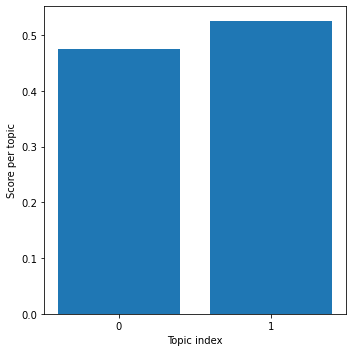

In [20]:
_ = lda_model.predict_heuristic(paris_doc)

Print topic distribution based on the statistical approach

tokens:
['pari', 'french', 'pronunci', 'paʁi', 'listen', 'capit', 'popul', 'citi', 'franc', 'estim', 'popul', 'resid', 'area', 'squar', 'kilometr', 'squar', 'mile', 'sinc', 'centuri', 'pari', 'one', 'europ', 'major', 'centr', 'financ', 'diplomaci', 'commerc', 'fashion', 'scienc', 'art', 'citi', 'pari', 'centr', 'seat', 'govern', 'pari', 'region', 'estim', 'offici', 'popul', 'percent', 'popul', 'franc', 'pari', 'region', 'gdp', 'billion', 'billion', 'accord', 'economist', 'intellig', 'unit', 'worldwid', 'cost', 'live', 'survey', 'pari', 'second', 'expens', 'citi', 'world', 'singapor', 'ahead', 'zürich', 'hong', 'kong', 'oslo', 'geneva', 'anoth', 'sourc', 'rank', 'pari', 'expens', 'par', 'singapor', 'hong', 'kong', 'citi', 'major', 'railway', 'highway', 'hub', 'serv', 'two', 'intern', 'airport', 'de', 'gaull', 'second', 'busiest', 'airport', 'europ', 'open', 'citi', 'subway', 'system', 'pari', 'métro', 'serv', 'million', 'passeng', 'daili', 'second', 'busiest', 'metro', 'system', 'europ'

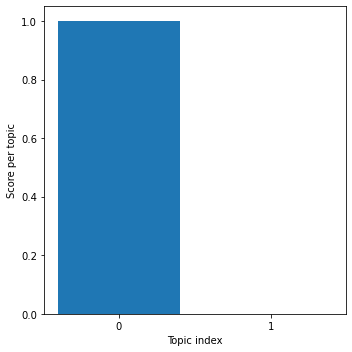

In [21]:
topic_proba = np.sum(lda_model.theta_extracted, axis=0) / lda_model.no_documents

_ = lda_model.predict_statistics(paris_doc)

While the heuristic method is more flexible when classifying new documents, it can be seen that Topic 0 (capitals) is by far the most suitable one, being spotted with high probability by the statistical approach.